In [1]:
import os
import numpy as np
import pickle
import shutil 
import pImpactR as impact
import matplotlib.pyplot as plt
import time

# Simulation Setting

In [2]:
npt = 1024
nTurn = 2048
Espread = 2.0e-3
pipe_radius = 0.029
std=0.1

# Prepare Lattice

In [3]:
beam,lattice=impact.readInputFile('IOTA.Chris.in')
beam.nCore_y = 1
beam.nCore_z = 1

reading ImpactZ input file (IOTA.Chris.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice = [ item for item in lattice if not item.type == '-8' ]
lattice[0].turns = 1
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = int(np.ceil(lattice[i].length*40))
        lattice[i].n_map = 1
    if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
        lattice[i].pipe_radius = pipe_radius

In [5]:
loop = lattice[0]
loop.turns = nTurn
nlinsert = lattice[1]
nlinsert.n_sckick = 2
nlinsert.n_map = 50
beam.n_particles = npt

In [6]:
NL_nu = nlinsert.tune_advance
NL_L  = nlinsert.length
NL_c  = nlinsert.transverse_scale_c
NL_t  = nlinsert.strength_t
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx
k

1.4544633270832747

In [7]:
nlinsert


             length: 1.8 [m]
           n_sckick: 2 [1]
              n_map: 50 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 0.029 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [8]:
ke = beam.kinetic_energy
freq = beam.frequency
mass = beam.mass
gam0 = 1.0+beam.kinetic_energy/mass
bet0 = np.sqrt(1.0-1.0/gam0**2)
bg0  = np.sqrt(gam0**2-1.0)
q_m  = beam.multi_charge.q_m[0]

In [9]:
elemTBT = impact.getElem('TBT_integral')
elemTBT.strength_t = NL_t
elemTBT.transverse_scale_c = NL_c
elemTBT.betx = betx
elemTBT.alfx = alfx
elemTBT.file_id = 10
elemTBT.pID_begin = 1
elemTBT.pID_end = npt

elemTBT_old = impact.getElem('TBT_integral_onMomentum')
elemTBT_old.strength_t = NL_t
elemTBT_old.transverse_scale_c = NL_c
elemTBT_old.betx = betx
elemTBT_old.alfx = alfx
elemTBT_old.file_id = 11
elemTBT_old.pID_begin = 1
elemTBT_old.pID_end = npt

lattice.append(elemTBT)
lattice.append(elemTBT_old)

# prepare particles

In [10]:
def Impact2norm(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,5] = -(np.sqrt(1.0-2.0*data[:,5]/mass/(bet0*bg0)+(data[:,5]/mass)**2/bg0**2)-1.0)
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2Impact(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = (bg0*np.sqrt(1/bet0**2+2.0*data[:,5]+data[:,5]**2)-bg0/bet0)*mass
    return data

In [11]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

x=get_truncated_normal(sd=std,low=-2*std,upp=2*std,n=npt*5)
pData=np.zeros([npt,9])
pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData[:,5] = pData[:,5]/0.2*Espread
pData[:,6] = q_m
pData[:,-1] = np.arange(1,npt+1)

impact.writeParticleData(norm2Impact(pData,bg0,bet0,1),ke,mass,freq)

# Run

In [12]:
def getLost():
    with open('lost_partcl.data') as f:
        for i, l in enumerate(f):
            pass
    return i

In [13]:
impact.writeInputFile(beam,lattice)
impact.run()
nLost0 = getLost()
indOff0,TBToff0 = impact.readTBT_integral(10)
indOn0,TBTon0 = impact.readTBT_integral_onMomentum(11)

In [14]:
with open('result.sphere.12sext','rb') as f:
    result = pickle.load(f)
    
i=0
for item in lattice:
    if item.type=='multipole_thin':
        item['KL_sext']=200.0*result.x[i]
        i=i+1
        
impact.writeInputFile(beam,lattice)
impact.run()
nLost1 = getLost()
indOff1,TBToff1 = impact.readTBT_integral(10)
indOn1,TBTon1 = impact.readTBT_integral_onMomentum(11)

In [15]:
print(nLost0,nLost1)

0 1


In [16]:
indOff0[:32]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [17]:
indOff1[:32]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

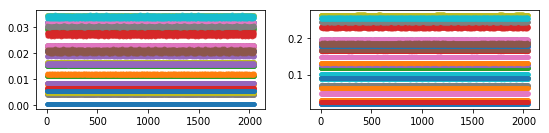

In [22]:
fig=plt.figure(figsize=(9,4))
plt.subplot(2,2,1)
for i in range(32):
    plt.plot(TBToff0[:,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(32):
    plt.plot(TBToff0[:,1,i],marker='.',ls='',alpha=0.7)

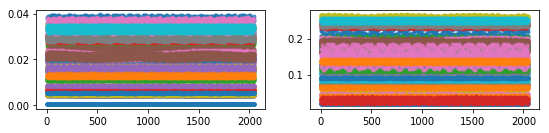

In [20]:
fig=plt.figure(figsize=(9,4))
plt.subplot(2,2,1)
for i in range(32):
    plt.plot(TBToff1[:,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(32):
    plt.plot(TBToff1[:,1,i],marker='.',ls='',alpha=0.7)

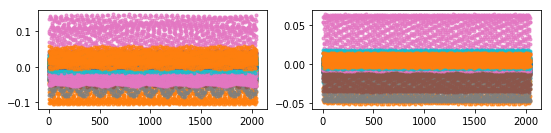

In [18]:
fig=plt.figure(figsize=(9,4))
plt.subplot(2,2,1)
for i in range(32):
    plt.plot((TBToff0[:,0,i]/TBToff0[0,0,i]-1.0),marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(32):
    plt.plot((TBToff0[:,1,i]/TBToff0[0,1,i]-1.0),marker='.',ls='',alpha=0.7)

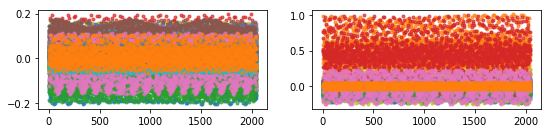

In [19]:
fig=plt.figure(figsize=(9,4))
plt.subplot(2,2,1)
for i in range(32):
    plt.plot((TBToff1[:,0,i]/TBToff1[0,0,i]-1.0),marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(32):
    plt.plot((TBToff1[:,1,i]/TBToff1[0,1,i]-1.0),marker='.',ls='',alpha=0.7)